In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
import pytorch_lightning as pl
import comet_ml

In [3]:
gpu = print(torch.cuda.get_device_name() if torch.cuda.is_available else 'cpu')

NVIDIA GeForce 940MX


In [16]:
AVAIL_GPUS = min(1, torch.cuda.device_count())

In [17]:
device = print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


In [6]:
from torchvision import datasets
import torchvision.transforms as transforms

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
])

In [7]:
ds_train = datasets.MNIST('/home/mohammadreza/share/data', train=True, download=False, transform=transform)
ds_test = datasets.MNIST('~/share/data', train=False, download=False, transform=transform)

/home/mohammadreza/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
!nvidia-smi

Wed Aug 25 11:52:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    N/A /  N/A |    481MiB /  4046MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jul_14_19:41:19_PDT_2021
Cuda compilation tools, release 11.4, V11.4.100
Build cuda_11.4.r11.4/compiler.30188945_0


In [10]:
BATCH_SIZE = 256 if num_gpu else 64
print('Number of alailable GPU: ', num_gpu)

Number of alailable GPU:  1


In [11]:
trainloader = torch.utils.data.DataLoader(ds_train, num_workers=2,
                                         batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(ds_test, batch_size=1000,
                                        shuffle=False, num_workers=2)

In [21]:
# defining the model with nn.Module
class MNISTModel(pl.LightningModule): # special calss allows you
    #to define many more components that are available to be trained at neural network
    def __init__(self, n=100):
        super(MNISTModel, self).__init__()
        self.l1 = nn.Linear(28 * 28, n)
        self.l2 = nn.Linear(n, 10)
        
    def forward(self, x):
        y_hat = self.l2(F.relu(self.l1(x.flatten(1))))
        # we need to apply the layers into flatten version of input
        
        return y_hat
    
    '''
    Till here is same as the method we used is from "nn.Sequenstial" to 
    
    "nn.Module". By follosing we define "train_step", "test_step", 
    
    "validation_step" and "prediction_step" by using inner mothods of
    
    "LightningModule"
    '''
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log('train_loss', loss, on_epoch=True, logger=True)
        # The "self.log" method, use internal pytorch.lightning facilities.
        # since this is for logging intermediate values
        return loss
        
    def validation_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log('test_loss', loss)
        return loss
    
    def predict_step(self, batch, *args):
        x, _ = batch
        return self(x)
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=0.02)
        return opt
        
            

In [22]:
model2 = MNISTModel()

In [23]:
X_batch, y_batch = iter(trainloader).next()

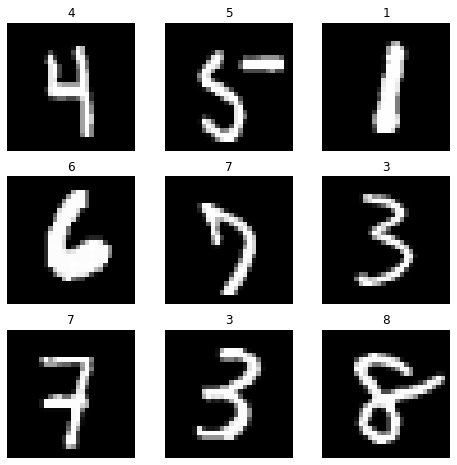

In [24]:
# Draw the images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds_train), size=(1,)).item()
    img, label = ds_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Trainer**  
_The most important part of the PyTorch Ligtning_  
It is a code that automates **traning**, **testing** and **validating** of your neural network. 
First you have construct an instance. Then fit it on your model.  

```python
trainer = Trainer()
trianer.fit(model, train_dataloader, val_dataloader)
```

In [30]:
trainer = pl.Trainer(
    gpus = AVAIL_GPUS,
    max_epochs=1,
    progress_bar_refresh_rate=20,
    auto_select_gpus=True
    
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [31]:
trainer.fit(model2, trainloader) #training

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 78.5 K
1 | l2   | Linear | 1.0 K 
--------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mohammadreza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mohammadreza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [32]:
# if you want to validate, you can also run validation

trainer.validate(model2, testloader) #testing 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 0.25884974002838135}
--------------------------------------------------------------------------------


[{'val_loss': 0.25884974002838135}]

In [33]:
p=trainer.predict(model2, testloader) #orediction on test data
#trainer.predict(model2, trainloader) #orediction on train data

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 235it [00:00, ?it/s]

### Tensorboard in PytorchLightning